# A simple Product Recommendation process basd on product descriptions

### Goal of the project

Given an amazon product description, I'm trying to see how what products will be 'recommended'. For example, if I'm purchasing a Banana Republic t-shirt, I want to see if the recommendation system just recommends other t-shirts or/and other Banana Republic products. For simplicity, I'll first visually inspect the results and then analyze results based on the descriptions.  The original metadata file had information on more than 1.5 million products. This json file has products from the "Clothing, Shoes and Jewelry" category. For this exercise, I'm using information from just 40000 products. 

### Motivation for this project

Any decent practical product recommender system will have been trained using a state-of-the-art deep learning architecture and with data from millios of products. What's more? Products evolve over time. Companies do away woth old products and try to promote new ones. This means they'll probably have to reinvent the wheel every now and then. They would have to obtain new reliable data, preprocess it and then train the model and evalute it's performance. 

But in this exercise, I'll try to obtain practical recommendations for products with absolutly no training at all. Sounds too good to be true? You're probably wondering where/how the magic happens. All I'm doing is transforming the descriptions of products using tf-idf vectorizer followed by computing their relative closeness (This step doesn't involve any modeling/using a complex deep learning architecture). Also,the time taken to compute the cosine similarities matrix was negligible.

But enough talk now. Let's get to business and see how this could work like a practical recommendation system!!!

### Practical application

Now, would something like be practical for a large e-commerce company like Amazon? Probably not! They have the resources and architecture to make sure that their recommender system(s) don't go out of date. They wouldn't have a problem gathering data from millions of products. After all, it's not practical to compute the cosine similarities of tens of millions of products each day!

So how could something like this be used? Small scale e-commerce/retail companies probably don't have millions of products. They may have a few 1000 / 100k products. That's certainly not enough data to train a state of the art model. Even if they are able to obtain enough data and come up with a well functioning model, they may not have the time and resources to keep updating the model to adjust to a rapidly changing market. But they could still come up with a neat recommender system if they have their product information in a file or a database. Their tradeoff would be the computation of the similarities matrix every time a product is outdated or a new one is added. For tens of thousands of images, the time taken to compute the similarities matrix is negligible. PS: It took me just around 3 minutes to compute the cosine similarities mareix for over 40000 product descriptions.

<font color='maroon'>

### Outline of the entire process:

1) Read the preprocessed amazon products file.

2) Transform the descriptions in the file using tf-idf vectorization by ignoring all stop words.

3) Transform the tf-idf vector to a numpy array.

4) Compute the relative cosine similarities matrix for all the product descriptions.

5) Given a product, I'll try to find the nine closest products. This will be determined by the magnitude of the computed  relative cosine similarities.

6) Using the 'imUrl' field in the preprocessed metadata file, we'll plot each of the 9 relatd products that are recommended.
</font>

In [1]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

### STEP 1

In [2]:
new_df = pd.read_csv('Clothing_file.csv')

In [3]:
#Inspecting the structure of the file
new_df.head()

Unnamed: 0                                              imUrl  \
0           0  http://ecx.images-amazon.com/images/I/41Nrta6E...   
1           1  http://ecx.images-amazon.com/images/I/419ED1sp...   
2           2  http://ecx.images-amazon.com/images/I/41qcR5%2...   
3           3  http://ecx.images-amazon.com/images/I/21hY4FKm...   
4           4  http://ecx.images-amazon.com/images/I/41IPc6iO...   

                                               title  \
0                Geneva Watch Face for Beading LWF26   
1     Iron Metal Dress Form Mannequin 29&quot; Brown   
2  Moneysworth and Best Shoe Care Neon Sport Lace...   
3    Operator Grade Field Jacket - Coyote Brown - XL   
4  Marquette University - Two-Toned Money Clip - ...   

                                         description  
0  Geneva watch face for beading.  This is a rect...  
1  Wrought Iron Metal Dress Form ~ Mannequin ~ Je...  
2  The colors are orange, lime and white. The col...  
3  The Operator Grade Field Jacket is soon to bec...  
4  Our Marquette University money clip is a hands...

In [4]:
len(new_df)

42685

We will now only choose the fields of interest

In [5]:
new_df = new_df[['imUrl', 'title', 'description']]

Dropping rows with NaN values

In [6]:
len(new_df)

42685

The index will be reset by ignoring the old indices.

### STEP 2

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=2, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(new_df.description)

### STEP 3

In [13]:
Xtfidf = Xtfidf.toarray()

In [14]:
Xtfidf.shape

(42685, 26477)

In [15]:
Xtfidf[0]

array([0., 0., 0., ..., 0., 0., 0.])

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

In [16]:
cos_matrix = cosine_similarity(Xtfidf[:3])

In [17]:
cos_matrix

array([[1.        , 0.        , 0.0191331 ],
       [0.        , 1.        , 0.02862734],
       [0.0191331 , 0.02862734, 1.        ]])

As expected, when a product correlation is computed with itself, 1 is the computed similarity. The first and third products are correlated too. But the magnitude is just ~0.02 which could indicate that they are entirely different products.

Since the relative similarity is computed for each element in the dataset, a square matrix is obtained.

Next, we'll compute the cosine similarities of all the products in our dataset.

In [18]:
words_siilar = cosine_similarity(Xtfidf)

In [19]:
words_siilar.shape

(42685, 42685)

We get a square matrix of size 40333x40333.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [20]:
def get_images(url):          
    resp = urllib.request.urlopen(url)                        # This step read the image from the url
    image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
    return image

In [21]:
def get_related_products(index_num, data = new_df):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    similar_prod_arr = words_siilar[index_num].argsort()[::-1][:10] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    prod_url = new_df['imUrl'].loc[index_num] # Obtaining the URL of the product image
    prod_img = get_images(prod_url) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,14))
    plt.subplot(4,3,2)
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    for i in similar_prod_arr[1:]:
        url = new_df['imUrl'].loc[i] # Retrieving the image URLs of all relatd products.
        img = get_images(url) # Retrieves the images of all items related to the product
        plt.subplot(4,3,j) 
        plt.imshow(img) # Plots the images
        plt.xlabel('Related product index: ' + str(i))
        j+=1

### STEP 6

Let's get started with the fun part already!

Before we begin seeing results right away, let us inspect th product in query.

In [8]:
new_df['description'].loc[1781]

'Columbia offers a wide variety of outdoor performance footwear, outerwear, sportswear, and accessories. Columbia products are engineered using the best technologies and highest quality materials, providing you with innovative products that are functional yet stylish and a great value.'

We have a footwear product from **Columbia** company. Let us inspect the recommended products and see if we get more products from Columbia.

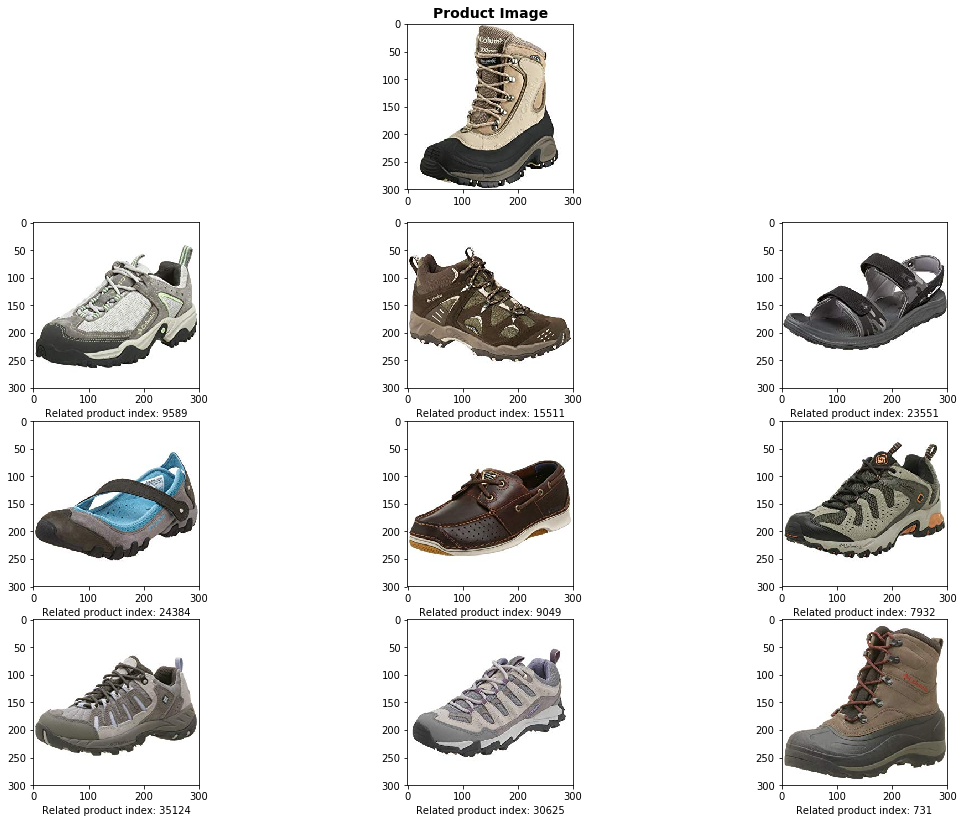

In [31]:
get_related_products(1781)

I've added code to record the index number of the product descriptions.

By just looking at the results, one may guess that these are other **North Face** products. Let's inspect some of the decriptions to be sure.

In [7]:
new_df['description'].loc[[23551, 24384, 9049, 30625]]

23551    Columbia offers a wide variety of outdoor perf...
24384    Columbia offers a wide variety of outdoor perf...
9049     Columbia offers a wide variety of outdoor perf...
30625    Columbia offers a wide variety of outdoor perf...
Name: description, dtype: object

The descriptions seem to be duplicates and hence the results!

Let's move on to the next product

In [8]:
new_df['description'].loc[6179]

'Oakland Raiders enameled pewter dangle NFL earrings.'

We have earrings from the **Oakland Raiderss** franchise. Oakland Raiders are an **NFL** team. Let's see if we get more products from the Raiders or something else.

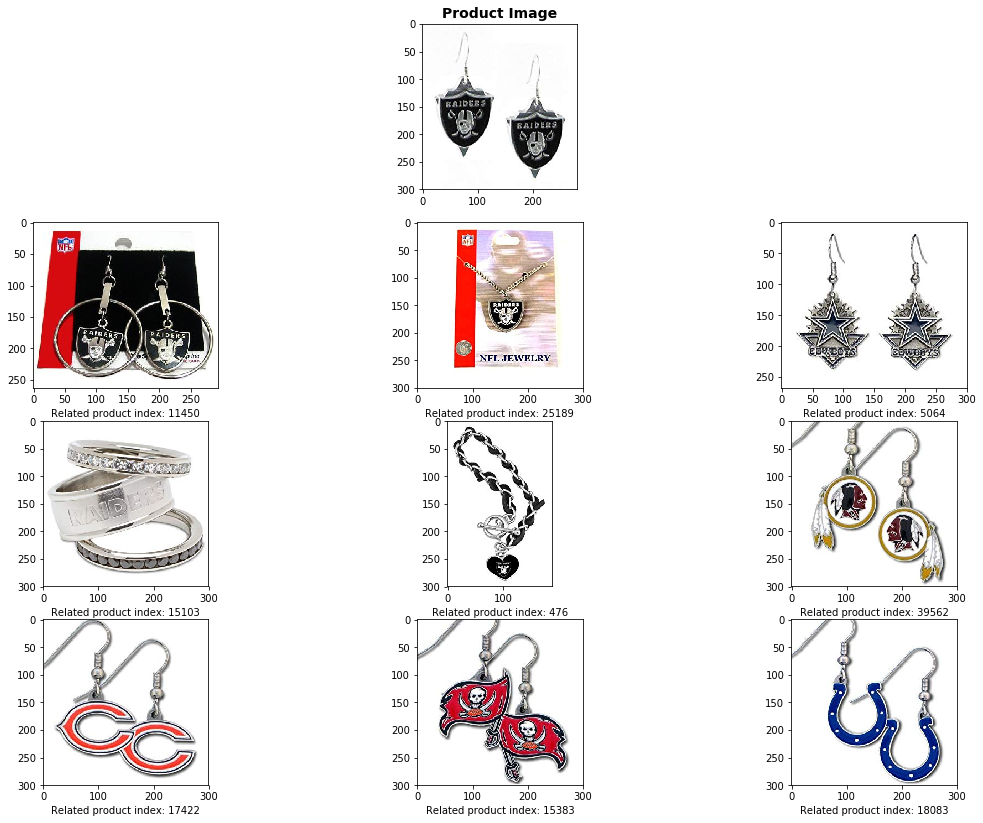

In [30]:
get_related_products(6179)

We seem to have gotten other earrings. Notice how the logo of the Dallas Cowboys is represented by a star. The first few recommendations seem to be of other Dallas Cow Boy earrings. Let's check out the other ones.

In [9]:
new_df['description'].loc[[17422, 15383, 18083]]

17422    NFL  Dangle Earrings
15383    NFL  Dangle Earrings
18083    NFL  Dangle Earrings
Name: description, dtype: object

We got dangle earrings of **other NFL teams**. 

In [10]:
new_df['description'].loc[581]

"Join the dark side this Halloween with this collectible Supreme Edition Darth Vader mask. Darth Vader is the main antagonist from the famous Star Wars films. Known for his mastery of the force and intimidating black suit and helmet you'll have everything you need to make your Darth Vader costume complete."

We have a Darth Vade helmet from Star Wars. Let's see if we get recommendations for more Star Wars merchandize or just more Vader themed items.

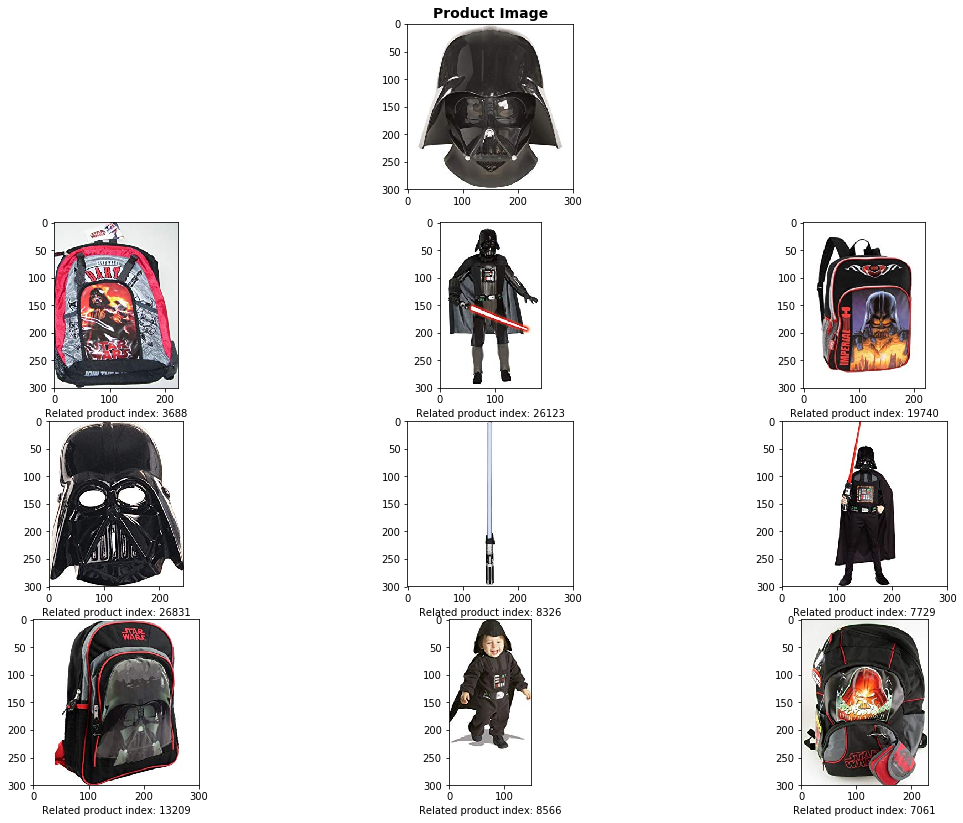

In [32]:
get_related_products(581)

Wow! All the recommendations seem to be from the Darth Vader themed  items.

In [12]:
new_df['description'].loc[762]

"Even if you've outgrown trick or treating, you're never too old wear a costume, do you want to revisit over-the-top halloweens you enjoyed as a child? Maybe you didn't get the costume you really wanted back then, whatever the reason - or the season - wearing a costume can be a lot of fun, on halloween you might dress up to take the kids trick or treating, to hand out candy, or for a party; or try getting together with friends or family and dressing up in coordinating costumes (ever wanted your own band of superheroes?), but just like kids enjoy dress-up play year around, so can you, costumes let you be someone completely different than you really are, or maybe they show a secret side you want to share and just like kids' costumes, rubie's adult costumes can be sexy, funny, scary, glamorous, or, whatever you're looking for, rubie's costume company has been bringing costumes and accessories to the world since 1950, as the world's leader we take seriously the mission to make dressing up 

We have a **Halloween costume** from **Rubie**. Let's see what we get as recommendations.

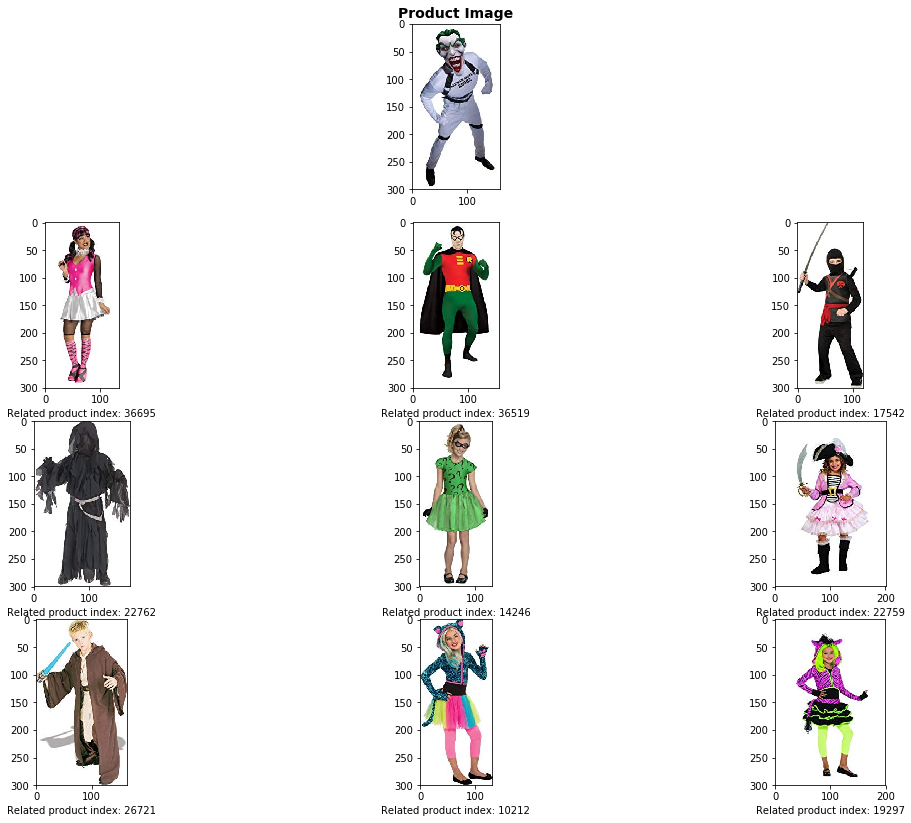

In [33]:
get_related_products(762)

We get other movie themed costumes and other costumes in general from Rubie's costume company. An interesting result, don't you think?

In [14]:
new_df['description'].loc[[22762, 26271, 19297]]

22762    Rubie's Costume Company has been bringing cost...
26271    You often see shirts, caps and jackets that fe...
19297    Rubie's Costume Company has been bringing cost...
Name: description, dtype: object

In [15]:
new_df['description'].loc[13859]

'The North Face Womens ModOsito Jacket'

We have a **womens' jacket** from **North Face**. Let's see if we're recommended other North Face products.

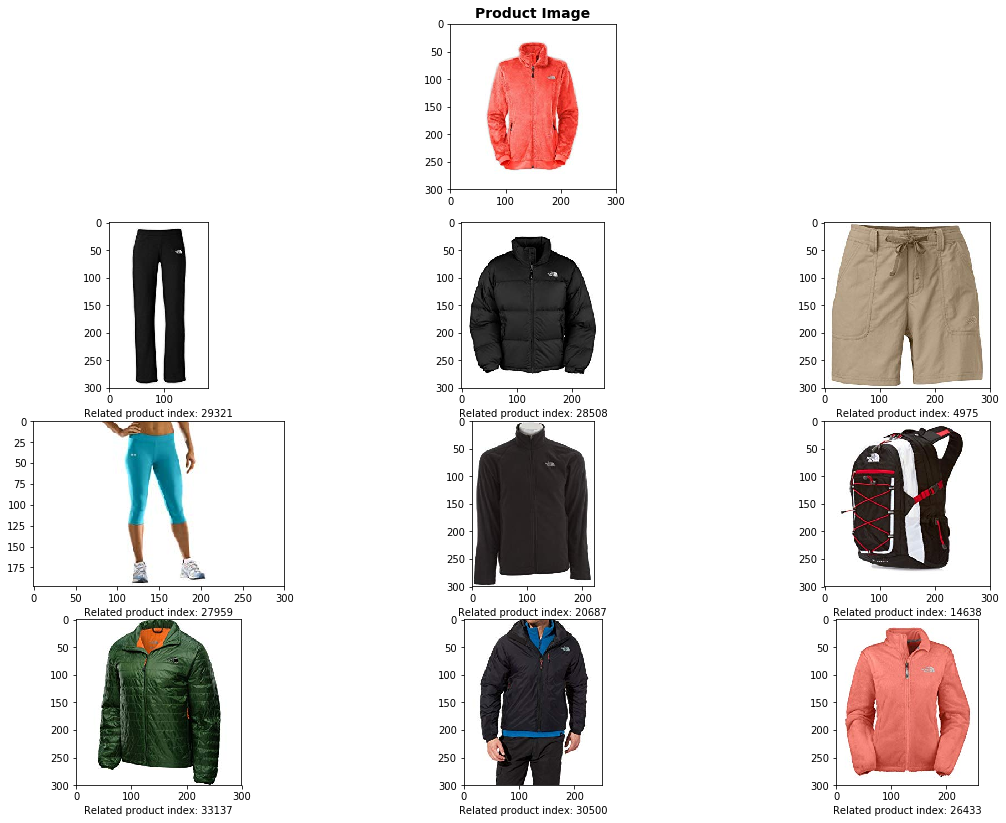

In [38]:
get_related_products(13859)

We indeed get other products from the North Face as recommendations and also some men's clothing items as well. 

In [21]:
new_df['description'].loc[31556]

'Perforated woven fabric delivers enhanced breathability during even the longest runs. Signature Moisture Transport System wicks sweat to keep you cool, dry, and light. Anti-microbial liner eliminates odors to keep your gear fresher, longer. New slimmer stretch waistband with internal drawcord for a lower profile comfort fit. Open leg design with bar tack detail for extra mobility without sacrificing coverage. Small hidden key pocket to stash your stuff. Reflective UA logo on front right hem adds extra visibility during low-light conditions. Allover print gets you noticed in the crowd. 3" inseam. Polyester. Imported.'

We have **ladies shorts** from **Under Armour**. Let's check out the recommendations.

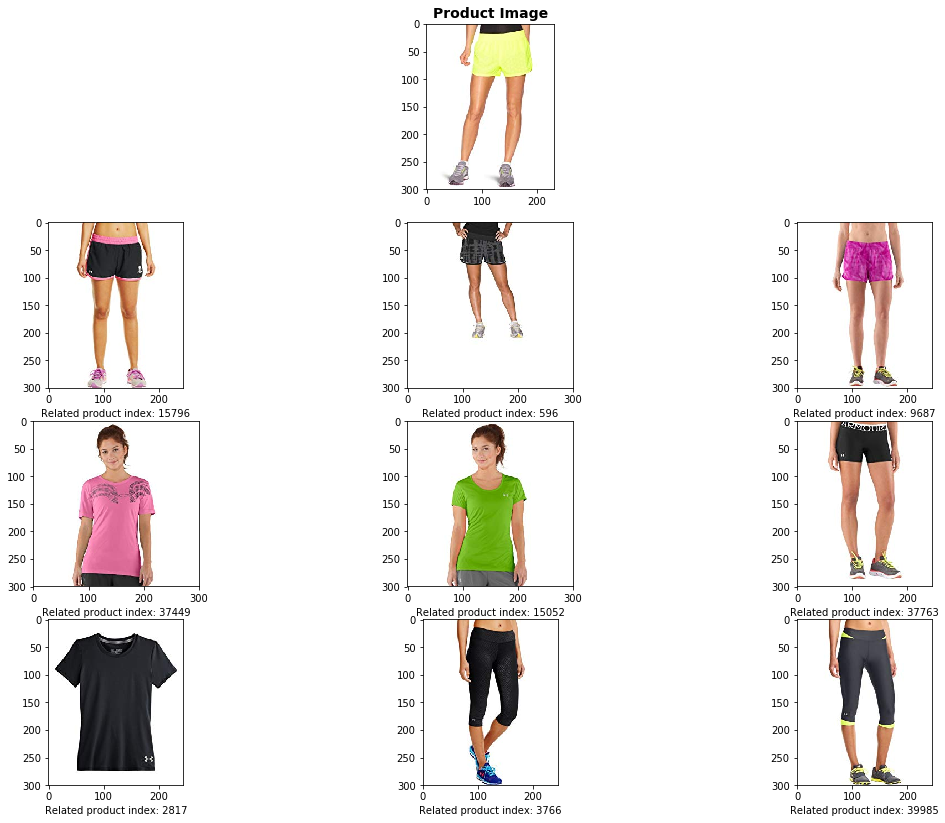

In [39]:
get_related_products(31556)

This was a very very interesting result. We get other ladies' sportswear as recommendations!

And that wasn't even hard to call! We do get recommendations of ther Harry Potter merchandize.

In [22]:
new_df['description'].loc[23854]

'Harry Potter Gifts Harry Potter Gryffindor Scarf Hat Cosplay ReplicaMovie: Harry PotterAcademy: GryffindorIncluding: Scarf + Hat+ XCOSER Metal LogoMaterial: CashmereColor:Gryffindor: Red/YellowHufflepuff:Black/YellowSlytherin:Green/GreyRavenclaw:Blue/GreySize: 255*25 CM&nbsp;Gryffindor: behalf of animals-lion. School Spirit: courage, vigor and chivalry, courage, boldness, forthright. Dean: Professor McGonagall (Transfiguration)'

We have a **Harry Potter scarf and hat**. Let's check out the recommendations.

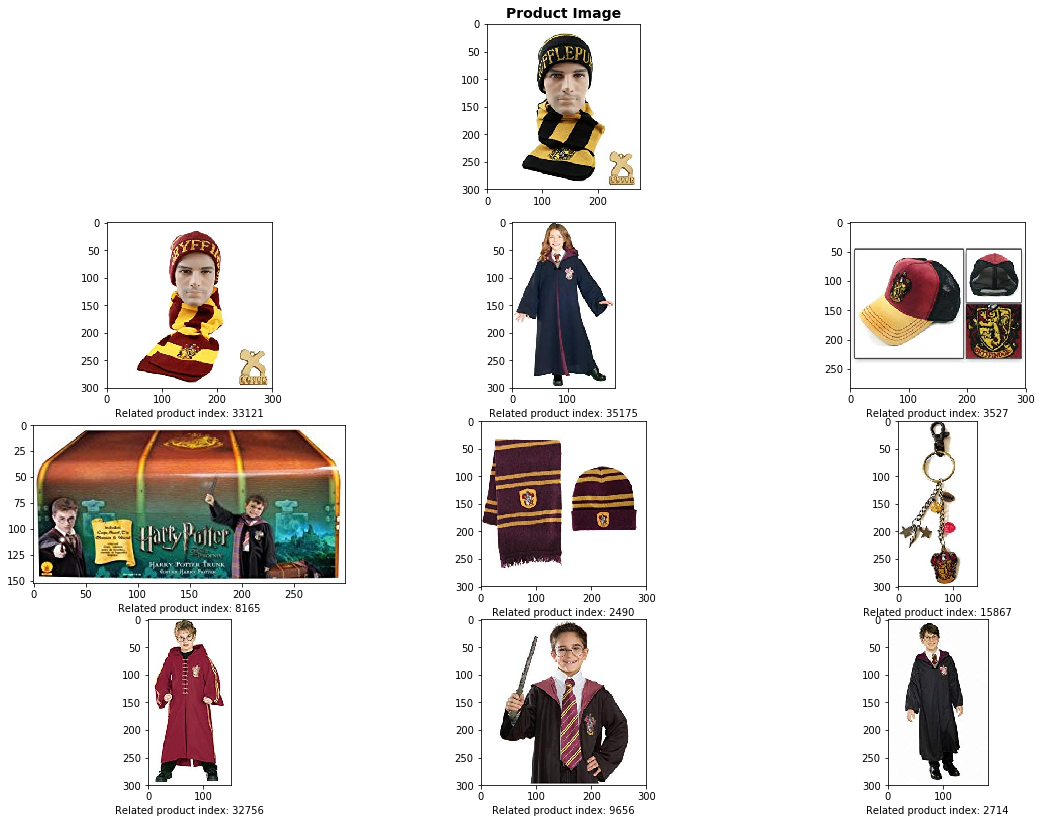

In [44]:
get_related_products(23854)

We get other recommendations of other Harry Potter merchandize. A useful result!

In [23]:
new_df['description'].loc[13873]

'Angry Birds Baseball Cap Kids Size Hat Adjustable Velcro Closure on Back 1 Size Fits Most Kids (Head Girth Max Approximately 21 Inches)'

We have a **baseball cap** from **Angry Birds**

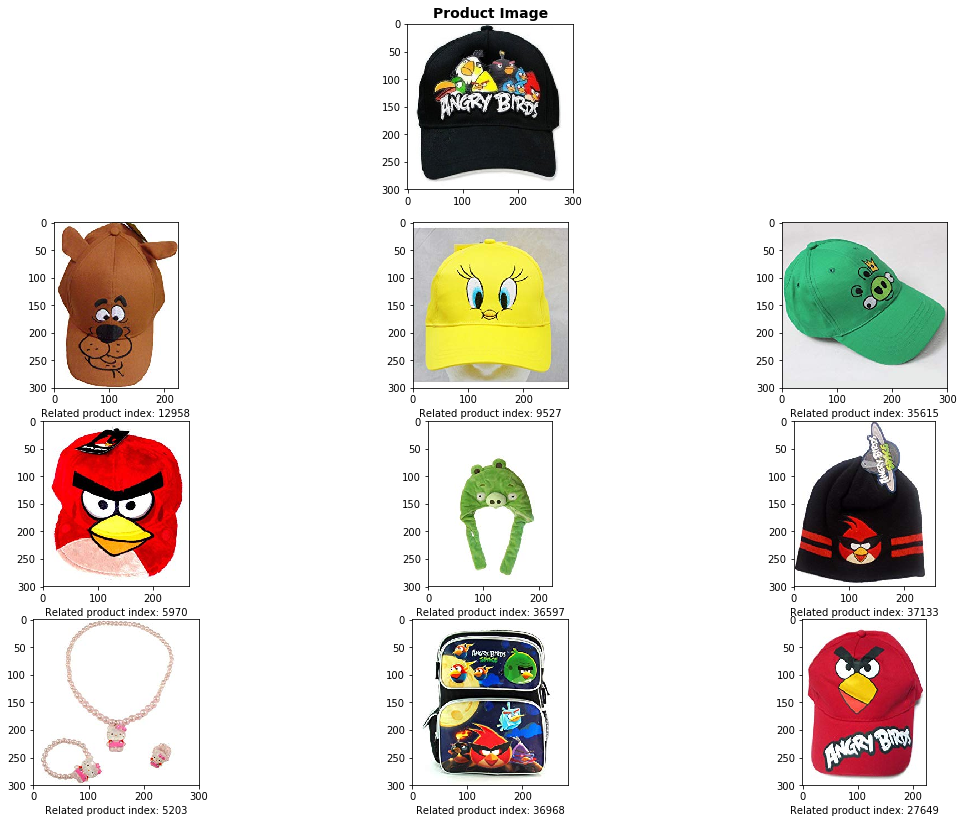

In [45]:
get_related_products(13873)

And we get other products from the **Angry Birds** merchandize. The exception is the hello kitty necklace. But nevertheless, an interesting recommendation.

In [24]:
new_df['description'].loc[12044]

"This New England Patriots -White- Women's Dazzle Trim Hooded Sweatshirt from Reebok has all the added detail you want to show your fanhood off in fashionable style. Features tackle twill applique wordmark with contrast color embroidery on chest and screen print team logo and Rbk logo on left sleeve."

We have a **women'shooded sweatshirt** from **New England Patriots**.

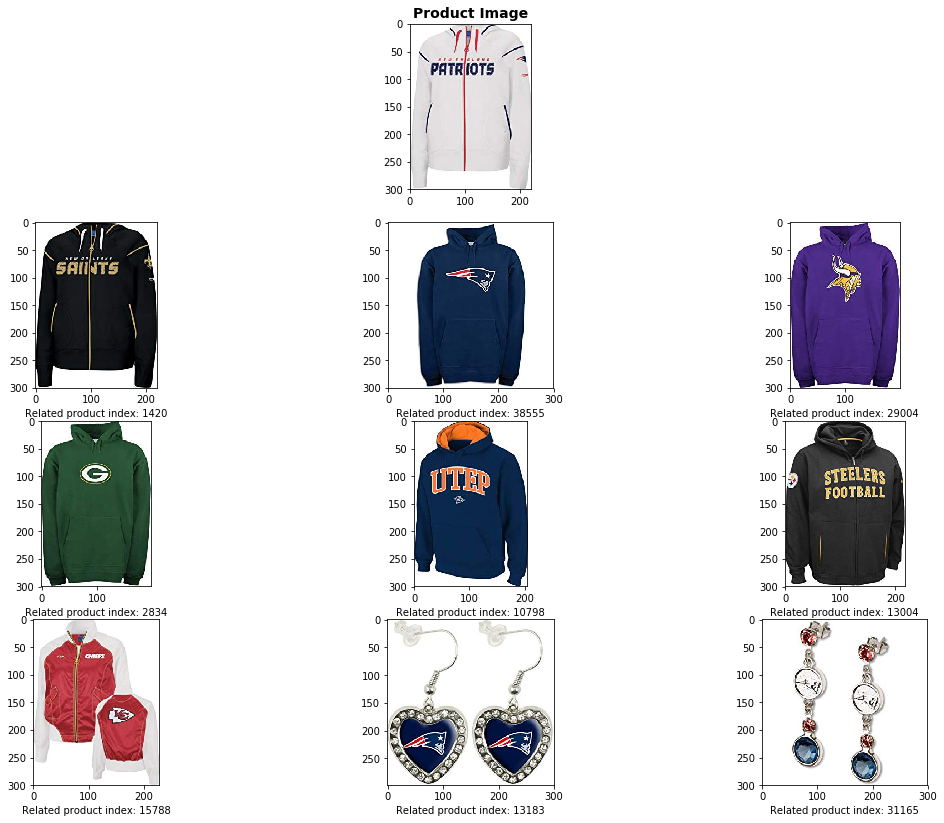

In [46]:
get_related_products(12044)

This time, we get other womens' hooded sweatshirts but from other **NFL** franchises. The last two results are earring from the same company. Basically, we've been recommended other womens' NFL products!

In [25]:
new_df['description'].loc[13388]

'Pink, Disney Princess Watch. Features images of Tianna, Cinderella, Aurora and Belle. Digital LCD display. 1 Year limited Warranty from M.Z. Berger & Co.'

We have a **Disney Princess** themed **watch**. More Disney themed products or other watches?

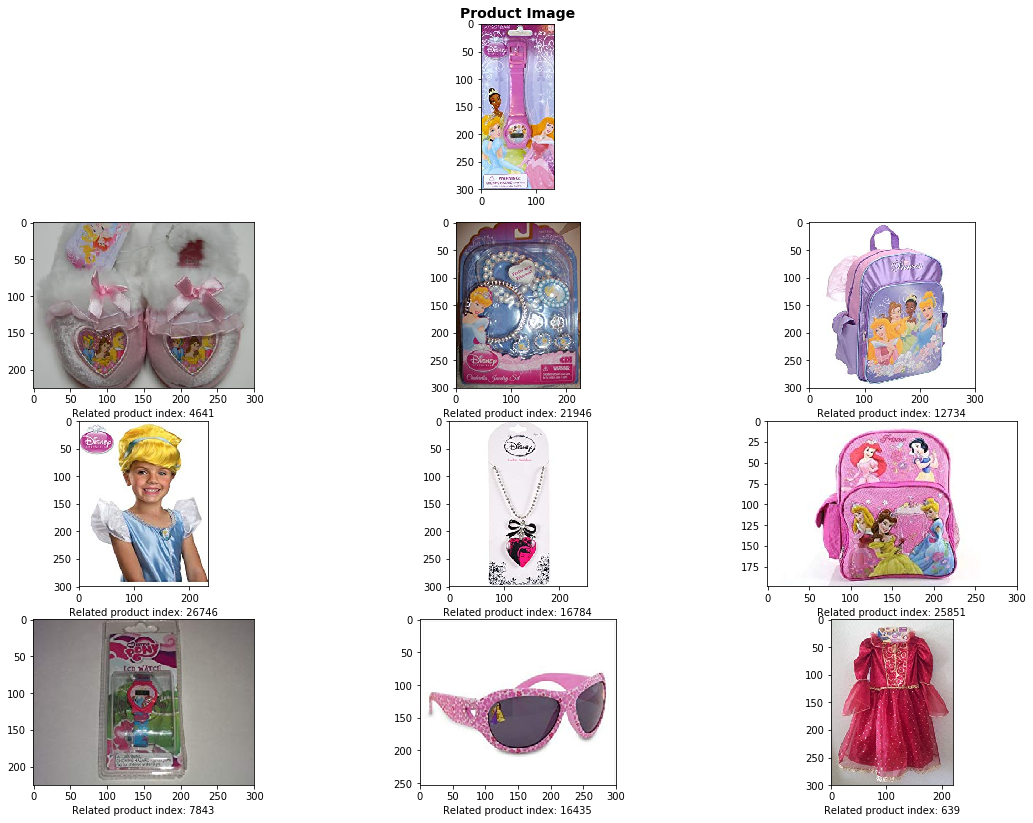

In [48]:
get_related_products(13388)

We have another great result. We get other **Disney princess** themed product recommendations.

In [27]:
new_df['description'].loc[31224]

"Saban's power ranger samurai"

We have am action figure from the **Power Rangers**

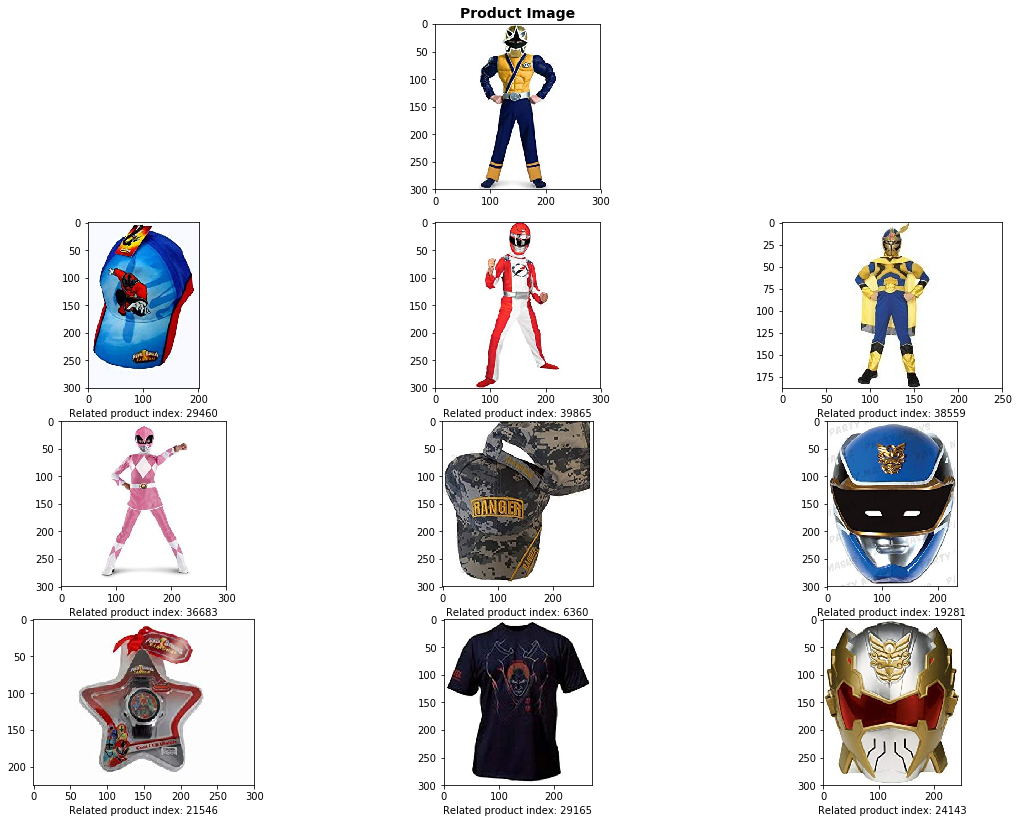

In [49]:
get_related_products(31224)

We get other Power Ranger themed products as recommendations. Let's check out the 4th and 8th recommendations as they seem different.

In [28]:
new_df['description'].loc[[6360, 29165]]

6360                      Ranger Embroidered Hat
29165    Cold Steel TH1 Samurai Tee Shirt Medium
Name: description, dtype: object

We have a "ranger" hat and a "Samurai" tee shirt which are key words from the main product's description and hence the results!

In [29]:
new_df['description'].loc[2014]

'Bazinga! Superman Cap Socks'

We have **socks** from Superman! Let's checkout the results!

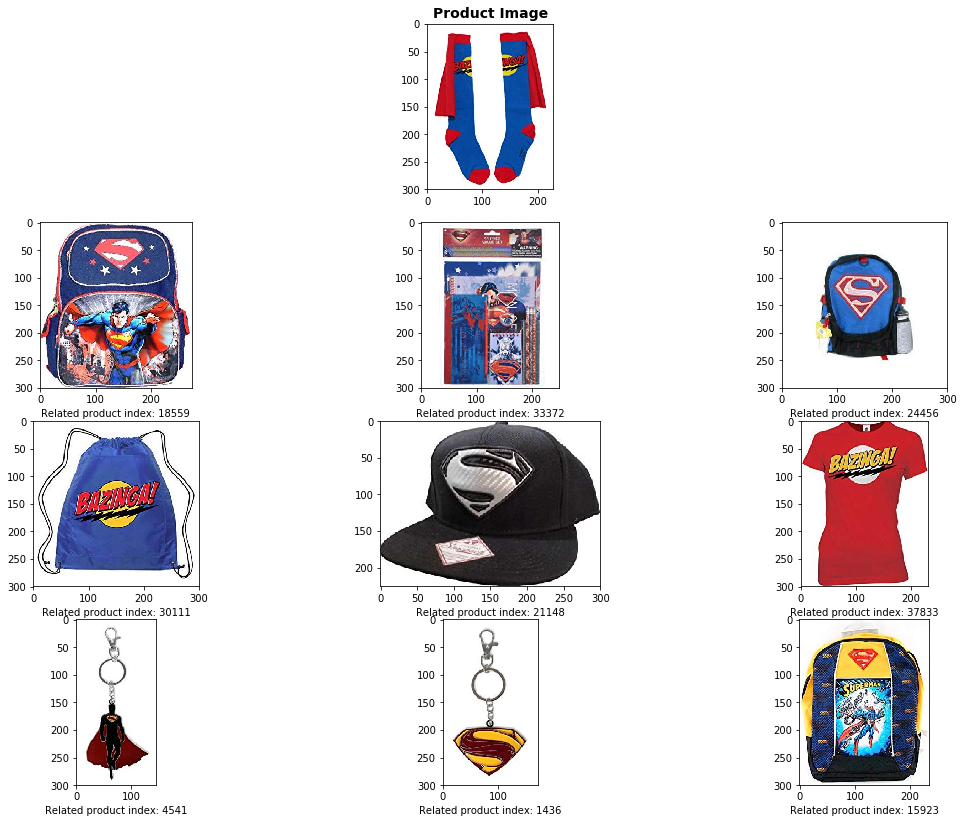

In [50]:
get_related_products(2014)

Indeed, we get recommendations of other **Superman** products.

In [30]:
new_df['description'].loc[40391]

'Puma Mens King Poly Soccer T-Shirt Train in Comfort! Puma Mens King Poly Soccer T-Shirt feature: Look good and play hard in a super functional t-shirt Performance t-shirt is great for training and practices with a lifestyle approach Sweat wicking Fabric stretches for a greater range of motion Applied Puma Cat logo on the upper right chest and both sleeves Tight weave mesh back with contrast stripe for superior breathability Even bottom hem See the Machine Wash a Line Dry 100% polyester Puma Soccer...The Nature of Performance.'

Here, we have a **Mens T-shirt** from **Puma**

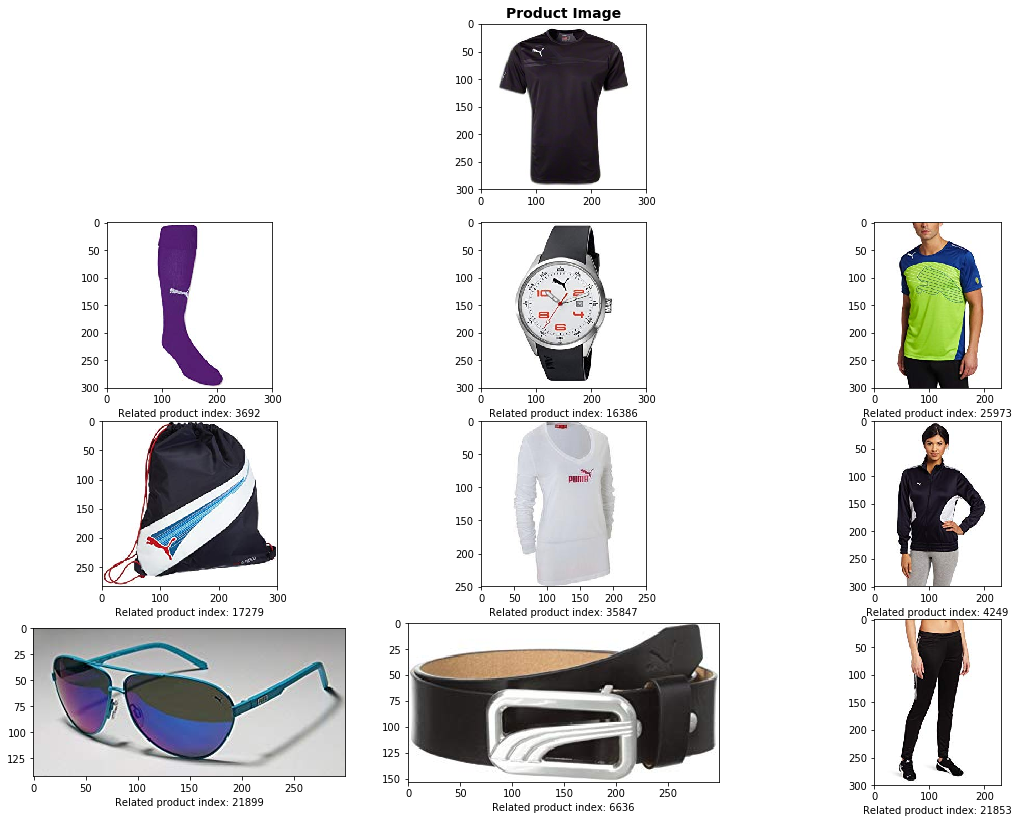

In [59]:
get_related_products(40391)

We get a couple ladies products (also from Puma) as recommendations but the others are other men's products from Puma.

In [31]:
new_df['description'].loc[42516]

'A notsobasic DriFIT tank, the Nike Victory DriFIT Tank for Women is flattering to the figure with a longer length and feminine neckline and performs like a champion, wicking moisture away from the skin to keep you cool, dry and comfortable.'

We have **ladies product** from **Nike** that appears to be sportswear.

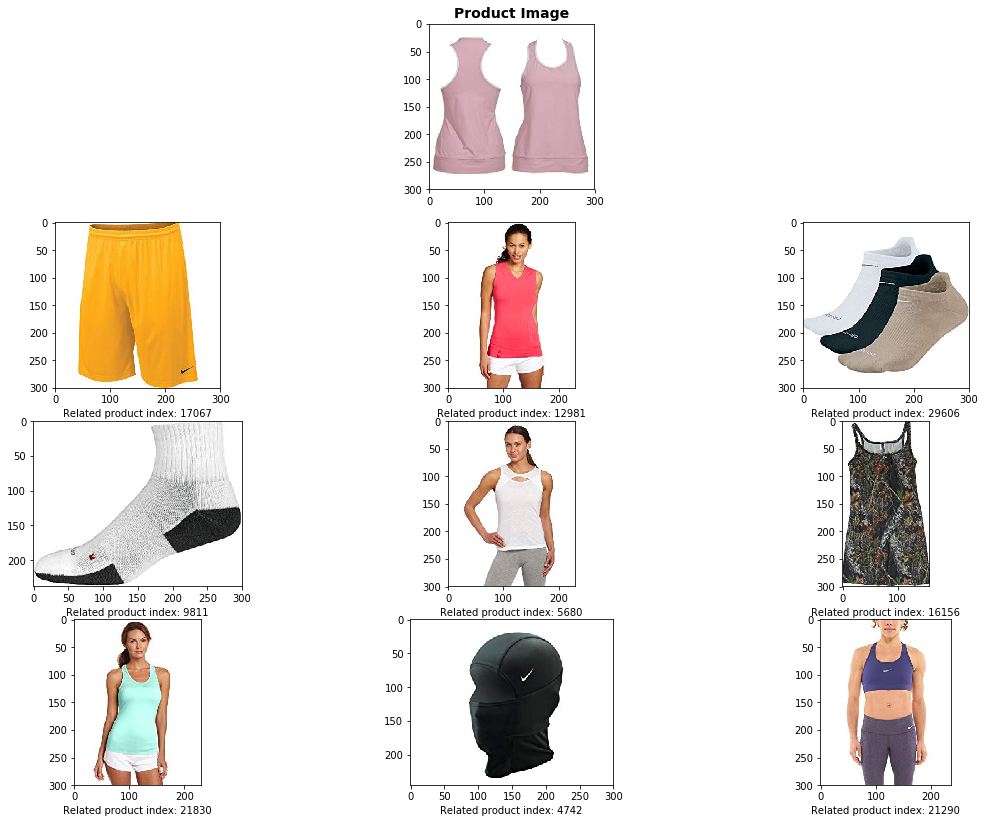

In [76]:
get_related_products(42516)

In [35]:
new_df['description'].loc[9811]

'The Nike Drifit essential anklet socks are a training essential. Featuring soft cotton fabric that helps pull sweat away from the skin, these socks have a supportive, durable fit.'

In [36]:
new_df['description'].loc[4742]

"Support your best performance with the no-distraction fit of the Nike Pro Combat Core 9 Inch Compression Shorts. Made to move as you move, these shorts feature fabric that rapidly pulls away sweat for high-speed flexibility and a clean fit under any uniform. The Nike Pro Combat Drifit Hood features a Dri-FIT fabric to help keep you dry and comfortable. It wick sweat away from your skin to the fabric's surface, where it quickly evaporates. This durable fabric also features four-way stretch for enhanced range of motion."

In [37]:
new_df['description'].loc[17067]

'Nike Men\'s Gold Team Fly DriFIT Shorts DriFIT knit body fabric short with terry cloth waistband and drawcord. Lower left contrast inserts. 10" inseam. 100 polyester. Imported. Adult Sizes: S 3XL. Color: Gold.'

We have a mens short and most of the recommendations are women's products!